In [1]:
import pandas as pd
import numpy as np
import scipy.io
import os
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, PCA
from AAUtoSig_init import AAUtoSig
from functions import cosine_HA

os.chdir("../../..")

In [2]:
def plotimgs(img_array):
    n_imgs = img_array.shape[-1]
    nrows = n_imgs//4 if n_imgs != 4 else n_imgs//2
    ncols = 4 if n_imgs != 4 else 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(20,5*nrows))

    if len(img_array.shape) != 3:
        img_array = img_array.reshape(32, 32, n_imgs)
    for i in range(n_imgs):
        ax = axs[i//ncols, i%ncols]
        ax.imshow(img_array[:,:,i], cmap='gray')
    plt.tight_layout()
    plt.show()

def train_AAUtoSig(epochs, model, x_train, criterion, optimizer, batch_size, non_negative = "all"):
    x_train_tensor = torch.tensor(x_train.values, 
                              dtype = torch.float32)
    trainloader = torch.utils.data.DataLoader(x_train_tensor, 
                                              batch_size=batch_size, 
                                              shuffle=True)
    

    training_plot=[]
    for epoch in range(epochs):
        train_loss = 0.0       
        model.train()
        for data in trainloader:
          # Output of Autoencoder
          reconstructed = model(data)#.view(-1,96)
          loss = criterion(reconstructed, data)#.view(-1,96)
          
          # The gradients are set to zero,
          # the the gradient is computed and stored.
          # .step() performs parameter update
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          train_loss += loss.item()
        training_plot.append(train_loss/len(trainloader))
        with torch.no_grad():
            if non_negative == "all":
                for p in model.parameters():#model.dec1.weight:
                    p.clamp_(min = 0)
            if non_negative == "bases":
                for p in model.dec1.weight:
                    p.clamp_(min = 0)
            model.eval()
    return(model, training_plot[-1])

### Swimmer data
Firstly lets investigate the swimmer data. The swimmer data consists of 256 32 by 32 black and white images of stick figures, with four limbs and a body that is the same in all images. Each of the limbs have 4 potential placements, meaning that there is 256 limb combinations (probably this means that there is one image for each combination - thus the representaiton is perfectly balanced). Four limbs with four placements means that we would get a perfect representation with 16 basis vectors.\
The data is retrived from https://www.stodden.net/Papers.html \

Let's load some data and look at some sample images:

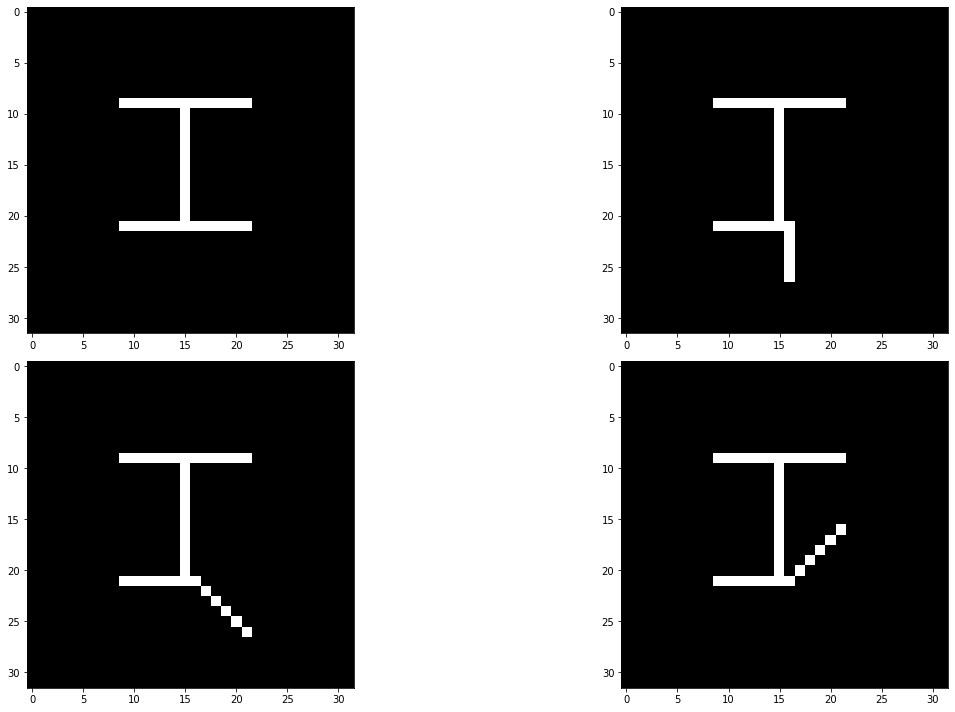

In [3]:
mat = scipy.io.loadmat('external_data/swimmer_data.mat')
swimmer_data = mat['Y']
swimmer_flat = swimmer_data.reshape(1024,256)

#display sample image
sample_imgs = swimmer_data[:,:,range(4)]
plotimgs(sample_imgs)

### NMF decomposistion
Firstly, we decompose the swimmer data with NMF and the frobenius norm, and show the resulting signatures

6.379307561957488


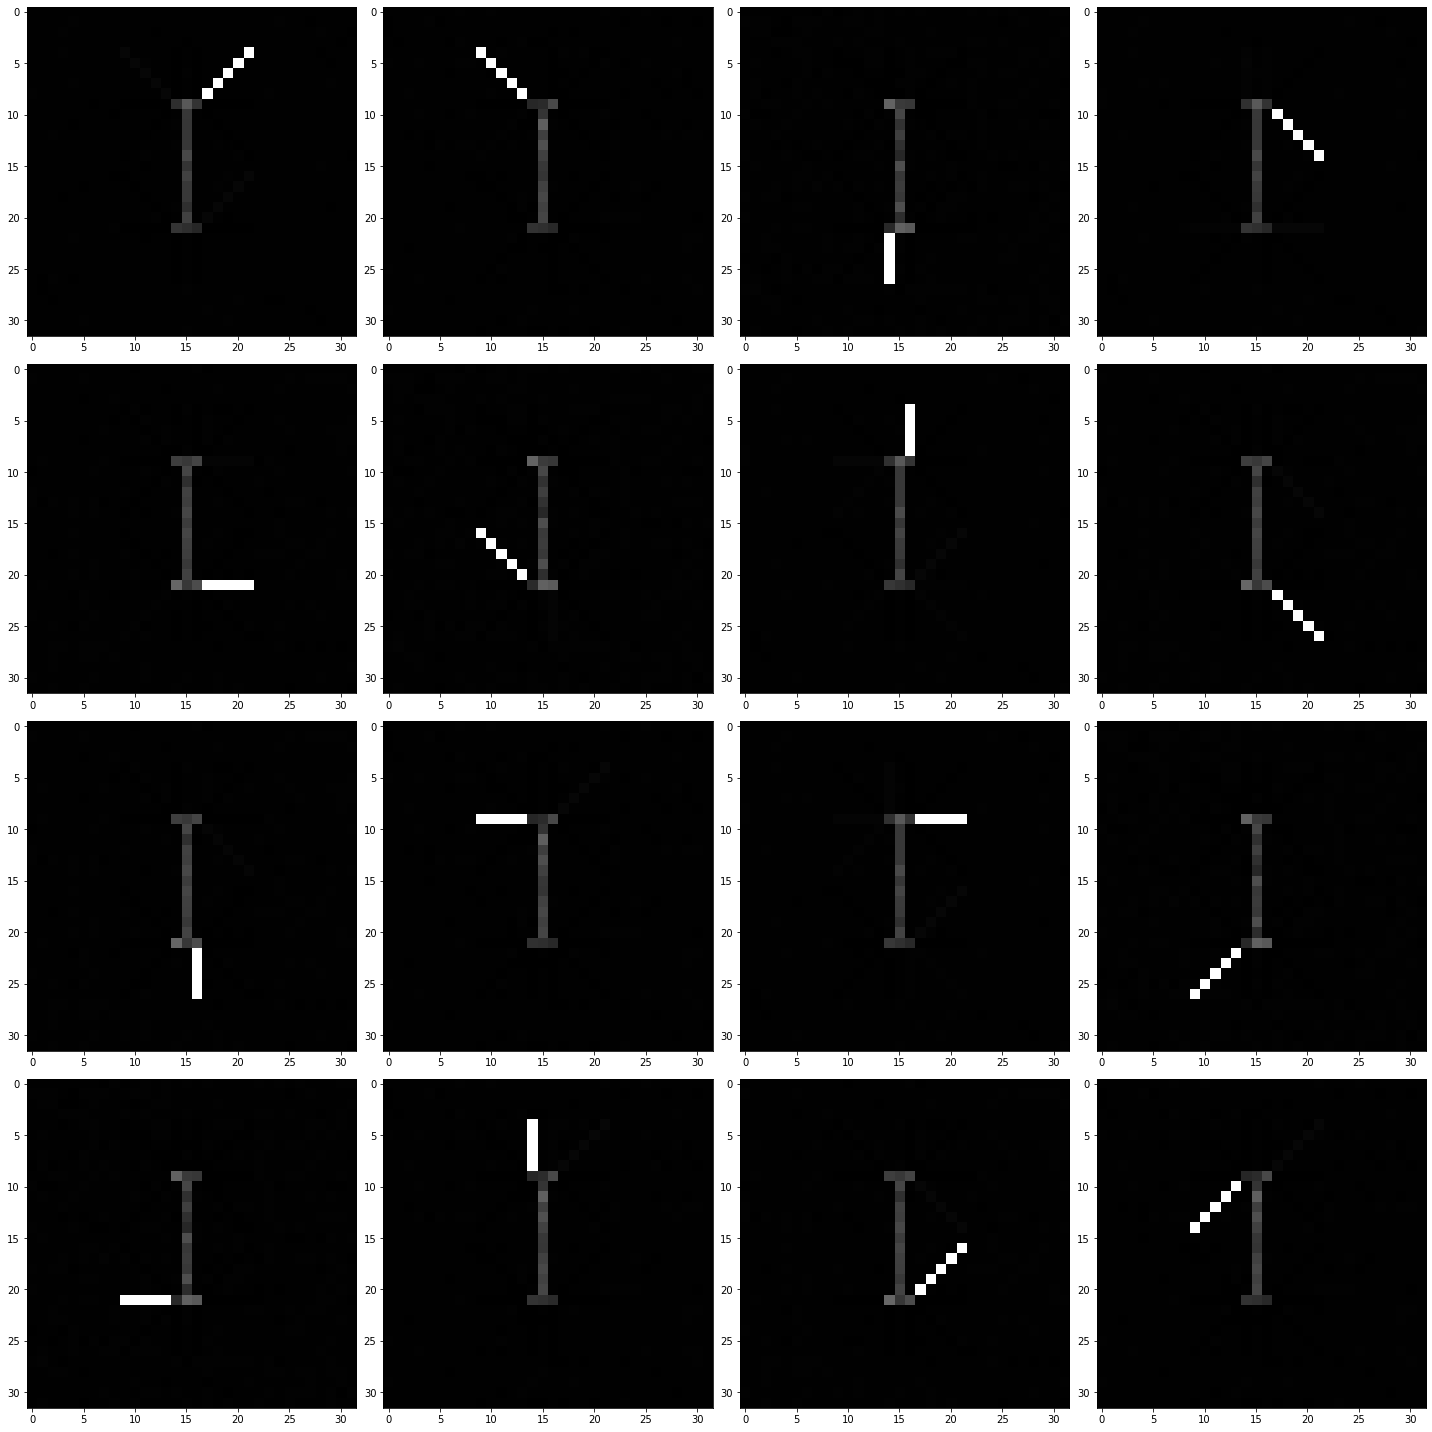

In [4]:
model = NMF(n_components=16, init='random', max_iter = 500, solver = 'mu', beta_loss = 2)
weights = model.fit_transform(swimmer_flat.T)
bases_NMF = model.components_
in_error_NMF = model.reconstruction_err_
print(in_error_NMF)

plotimgs(bases_NMF.T)

### AE decomposistion
Secondly we repeat the decomposistion using a one-hidden-layer autoencoder with relu activation, and investigate the resulting basis vectors.

This goes through the bsis vector when no, all and the decoding parameters have non-negativity costraints.

It seems like the last two sets of basis vectors are similiar, and even ordered the same.

Basis vectors with no params constrained


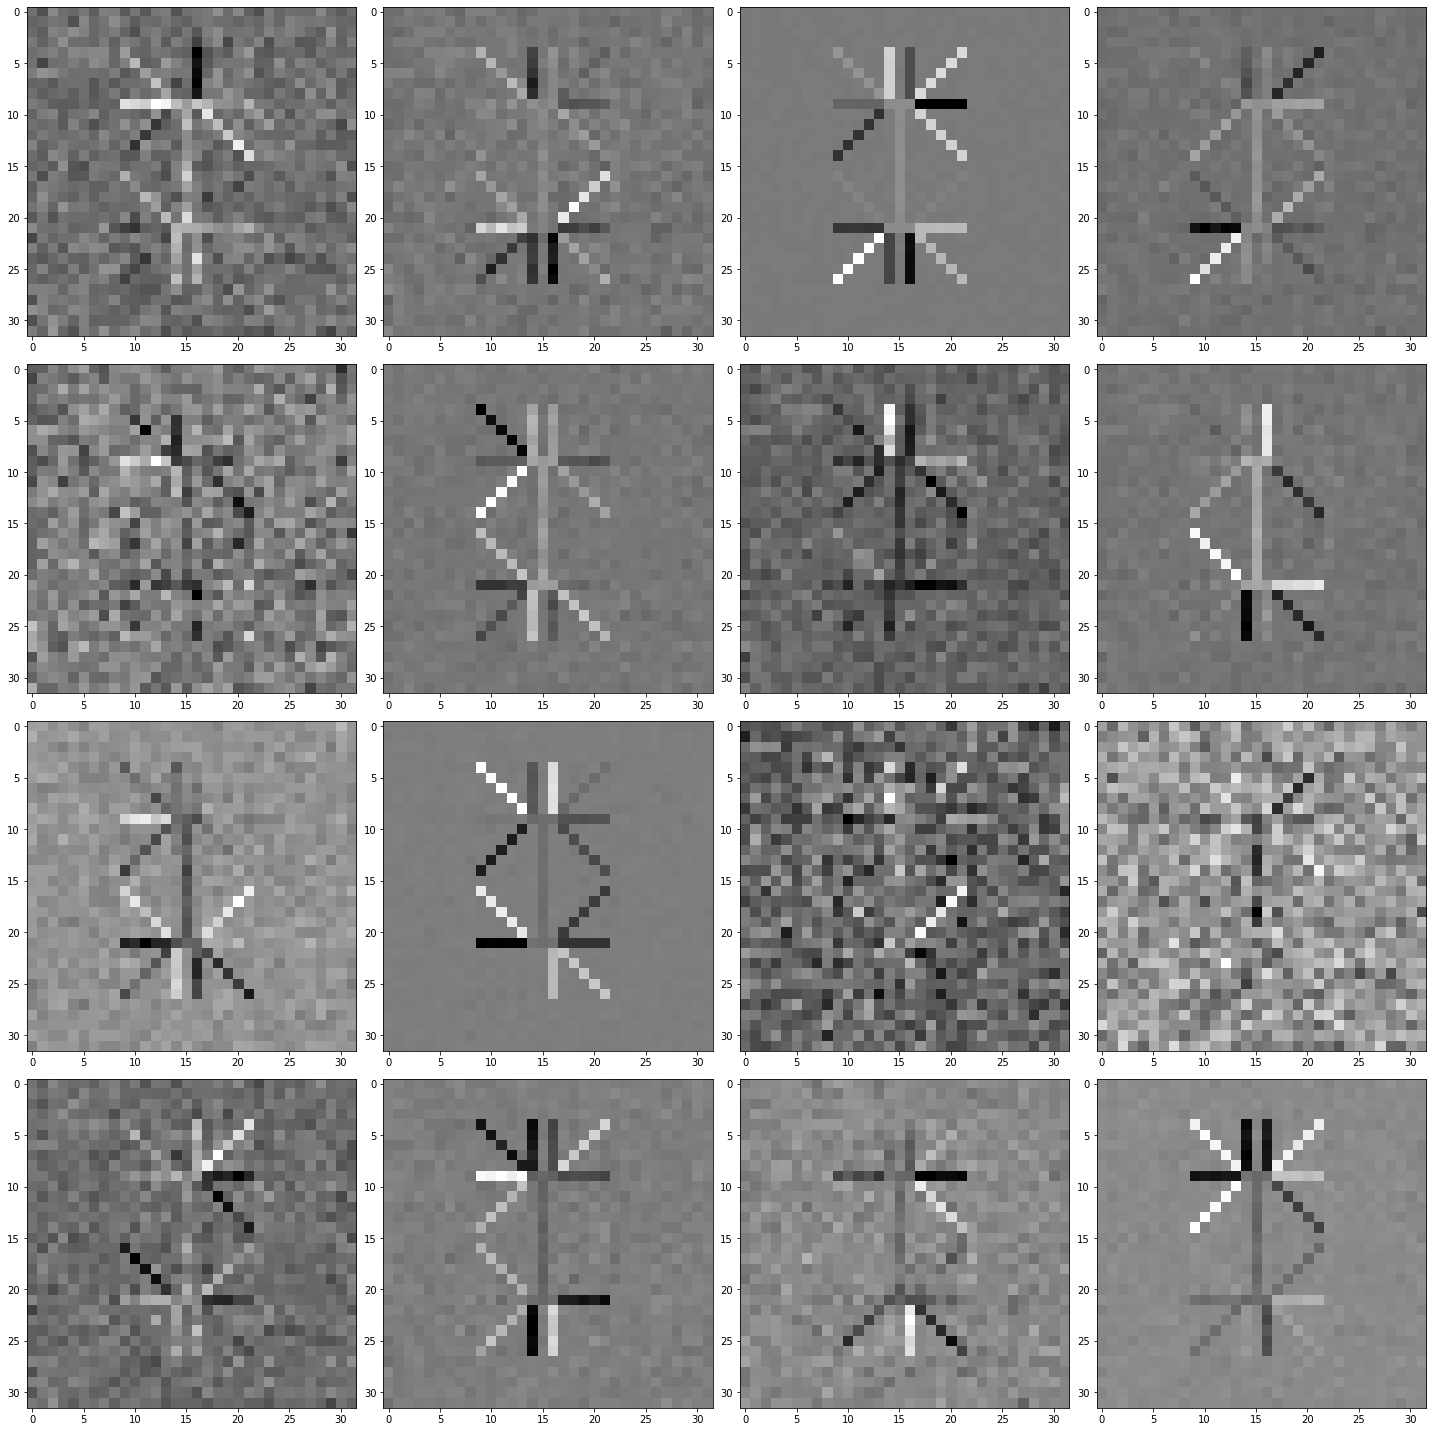

Basis vectors with all params constrained


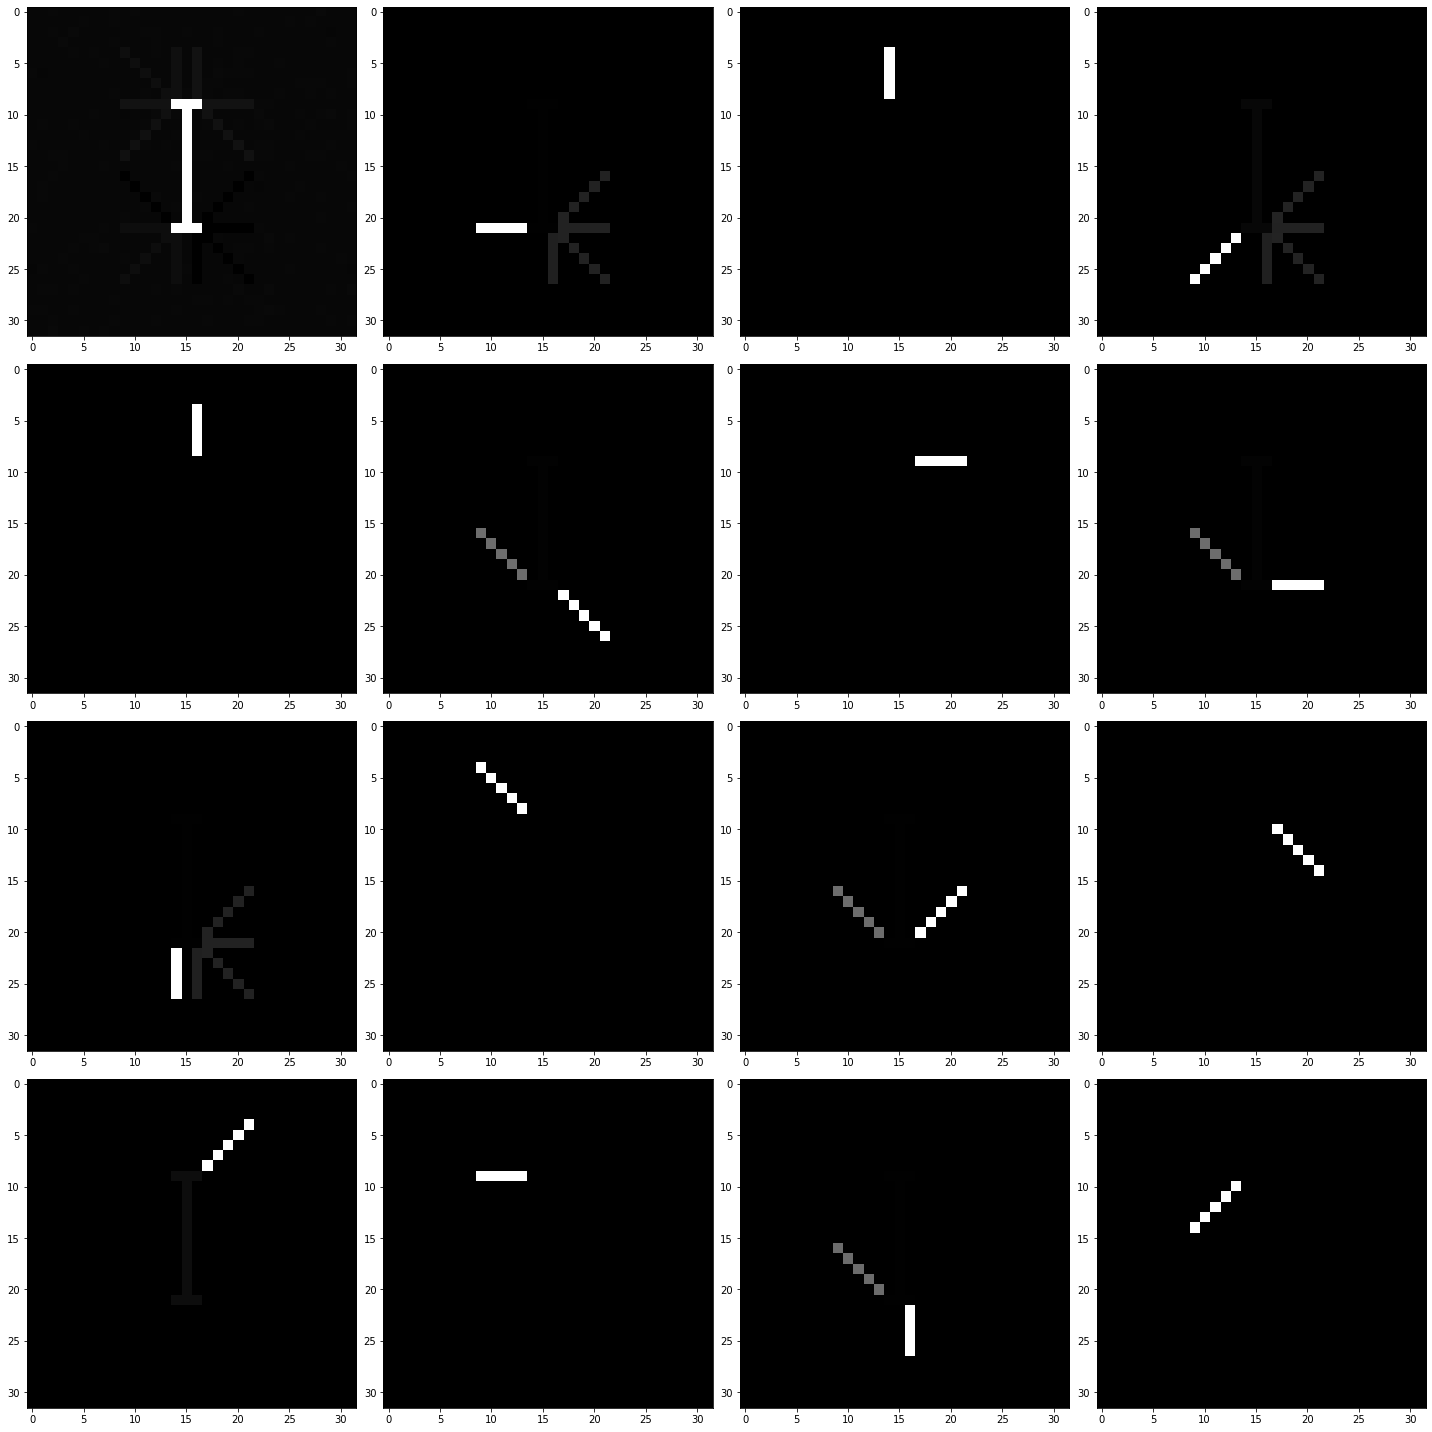

Basis vectors with bases params constrained


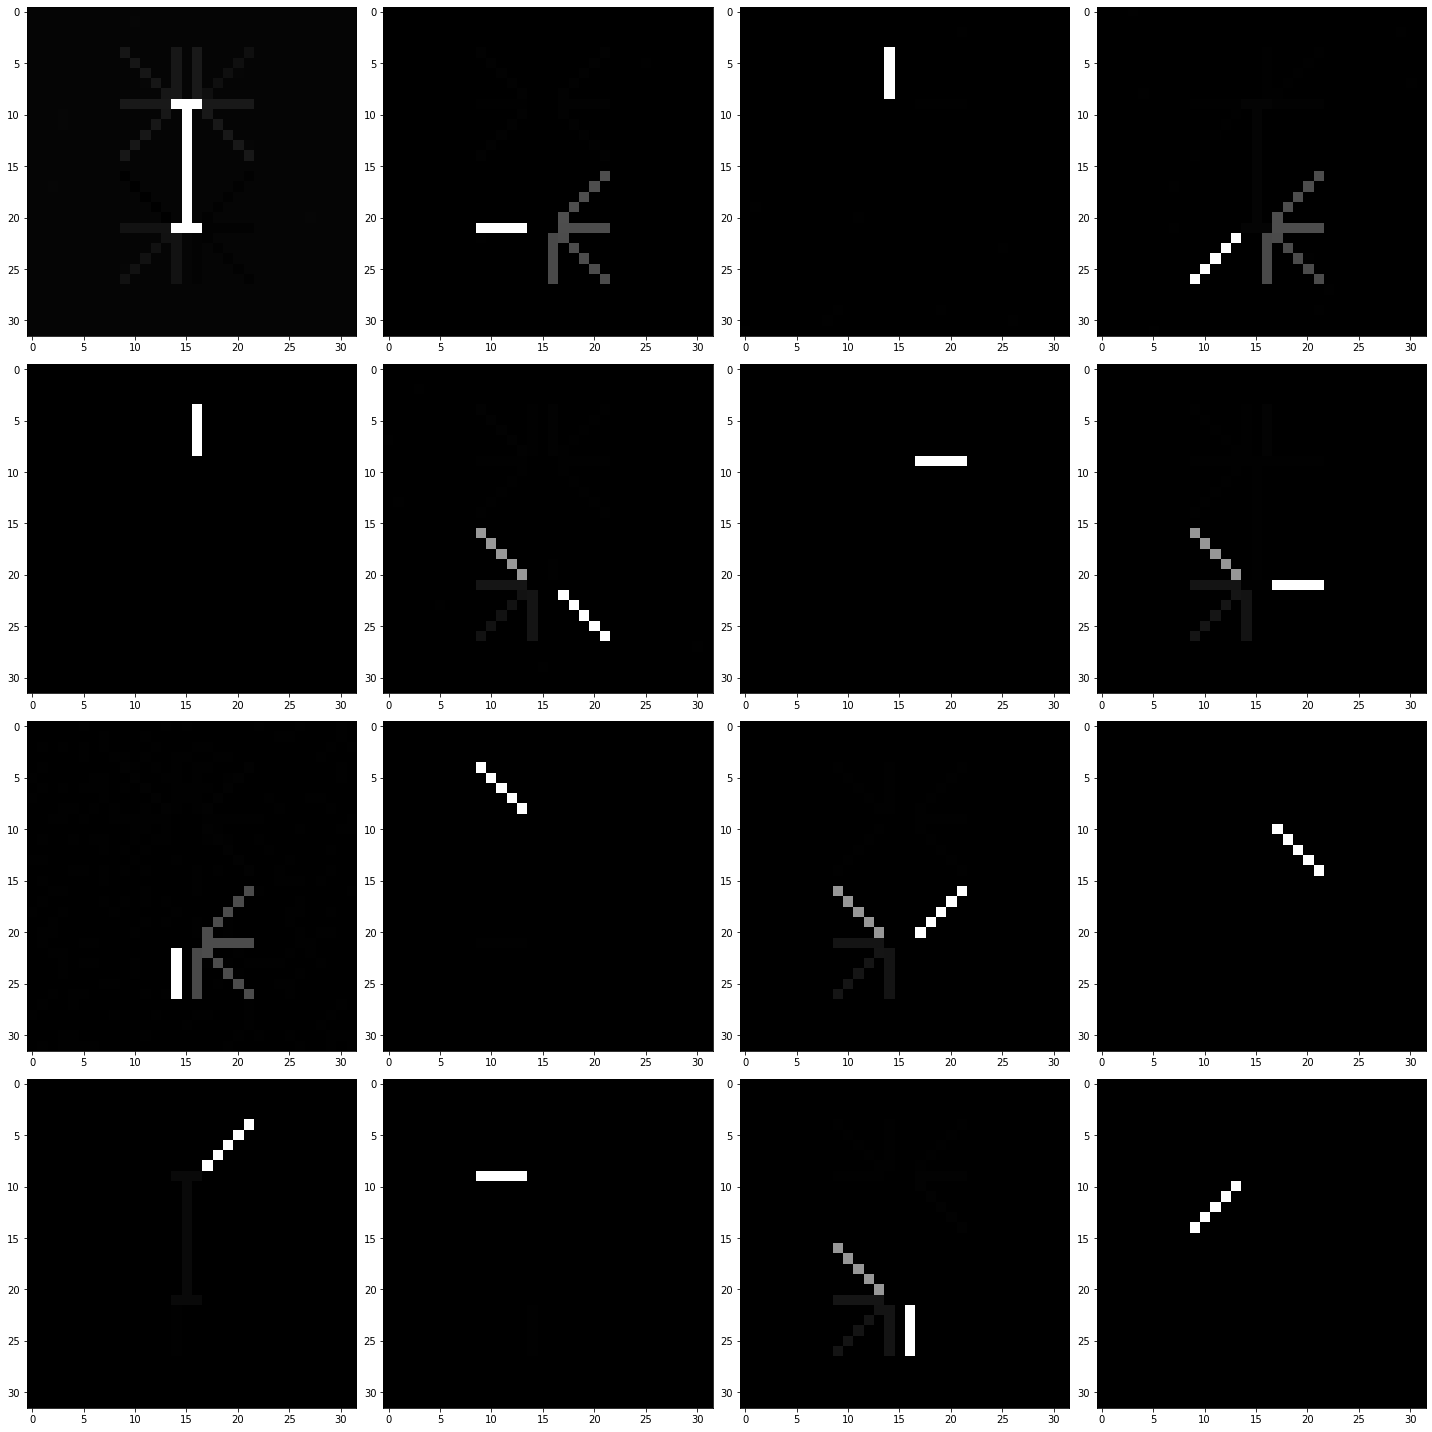

[0.019406243867706507, 0.9441360216587782, 0.007370932522462681]


In [5]:
model = AAUtoSig(1024, 16)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = torch.nn.MSELoss()

in_error_AE = []
bases_AE = np.zeros((1024, 16, 3))
non_negative = ["no", "all", "bases"]
for i in range(3):
    _, in_error = train_AAUtoSig(epochs = 500, model = model, x_train = pd.DataFrame(swimmer_flat).T, criterion = criterion, optimizer = optimizer, batch_size = 16, non_negative = non_negative[i])
    in_error_AE.append(in_error)   
    bases_AE[:,:,i] = model.dec1.weight.data.numpy()
    print("Basis vectors with " + non_negative[i] + " params constrained")
    plotimgs(bases_AE[:,:,i])
print(in_error_AE)

### PCA
Now we decompose using PCA, so see if orthogonalizing the basis vectors from AE will result in PCA bases - as claimed by Plaut

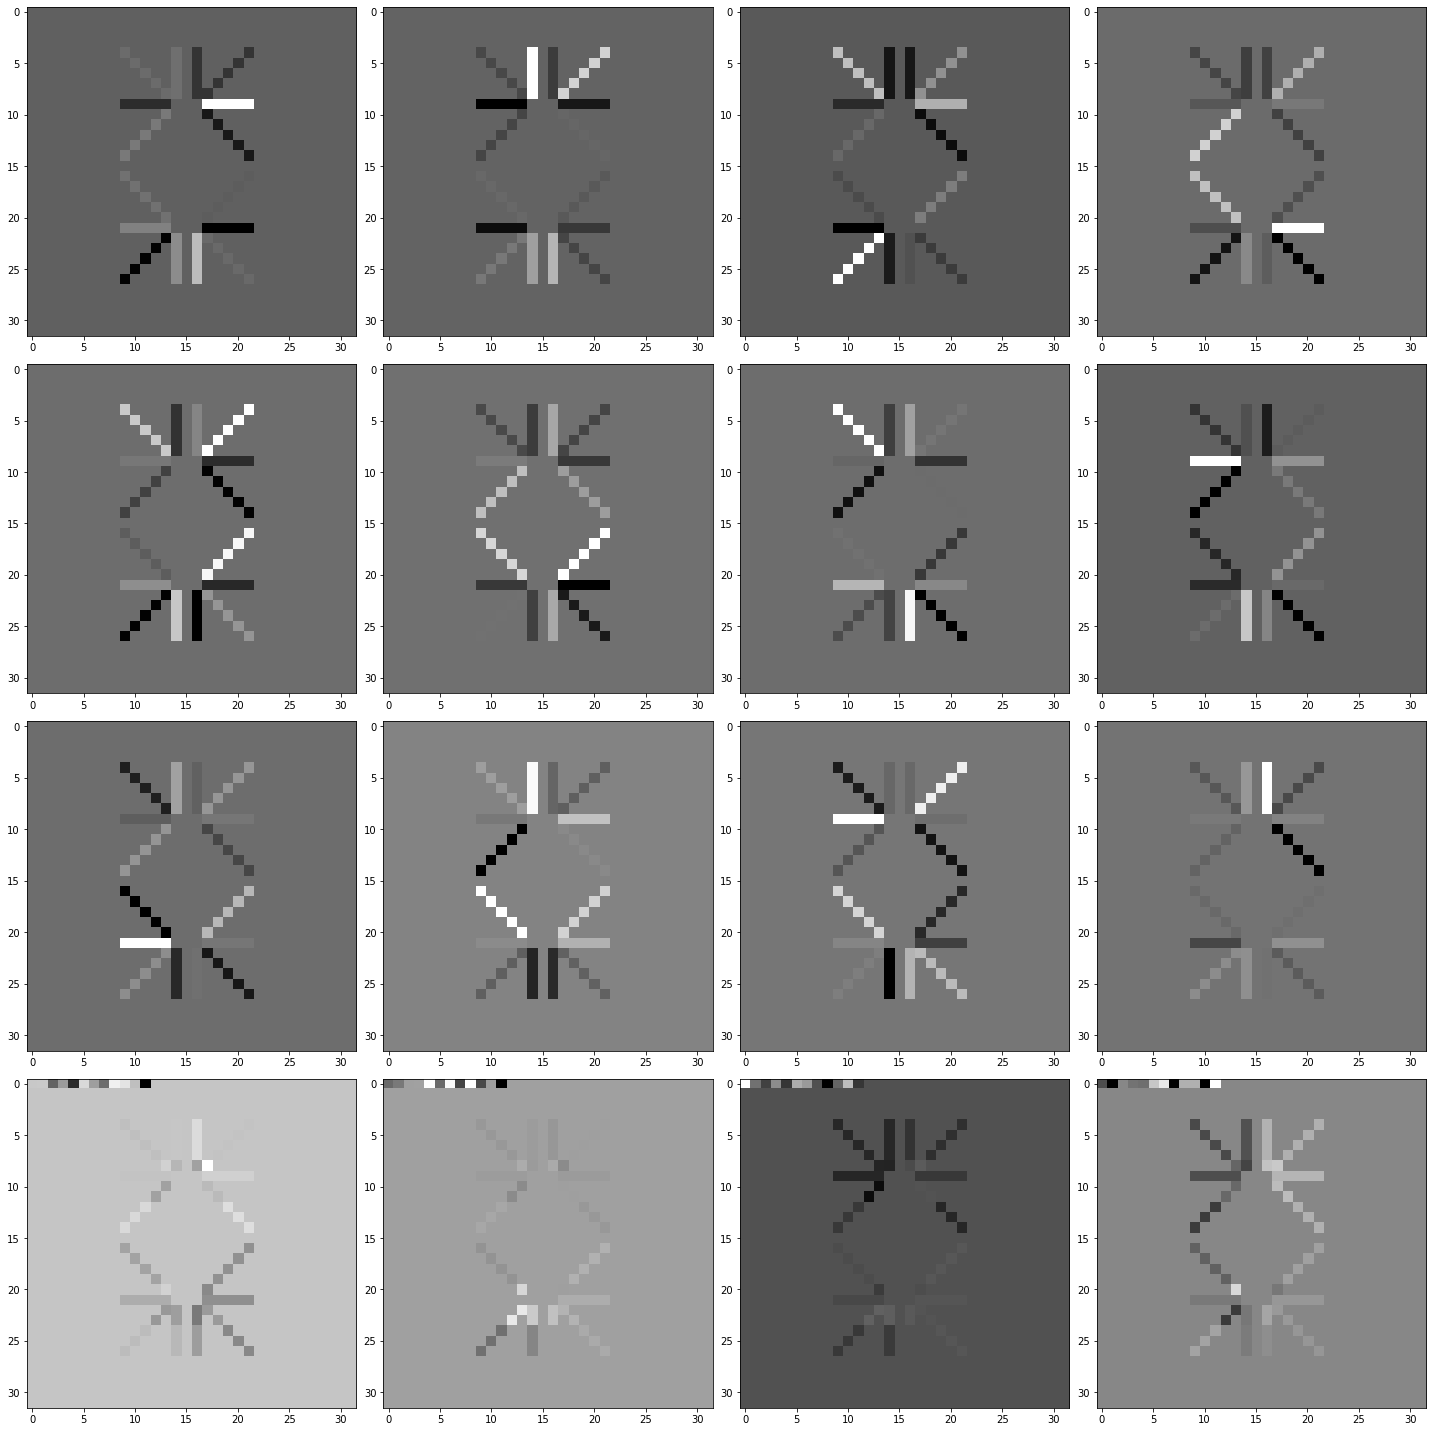

In [6]:
model_PCA = PCA(n_components=16)
model_PCA.fit(swimmer_flat.T)
bases_PCA = model_PCA.components_

plotimgs(bases_PCA.T)


### Transform AE bases to PCA
By Plaut we should get the PCA representation by orthogonalizing the AE bases with the Gram Schmidt process. We also shitf the base ordering to match the ordering from PCA to be able to compare

0.6108472707919413
0.2763574633101177


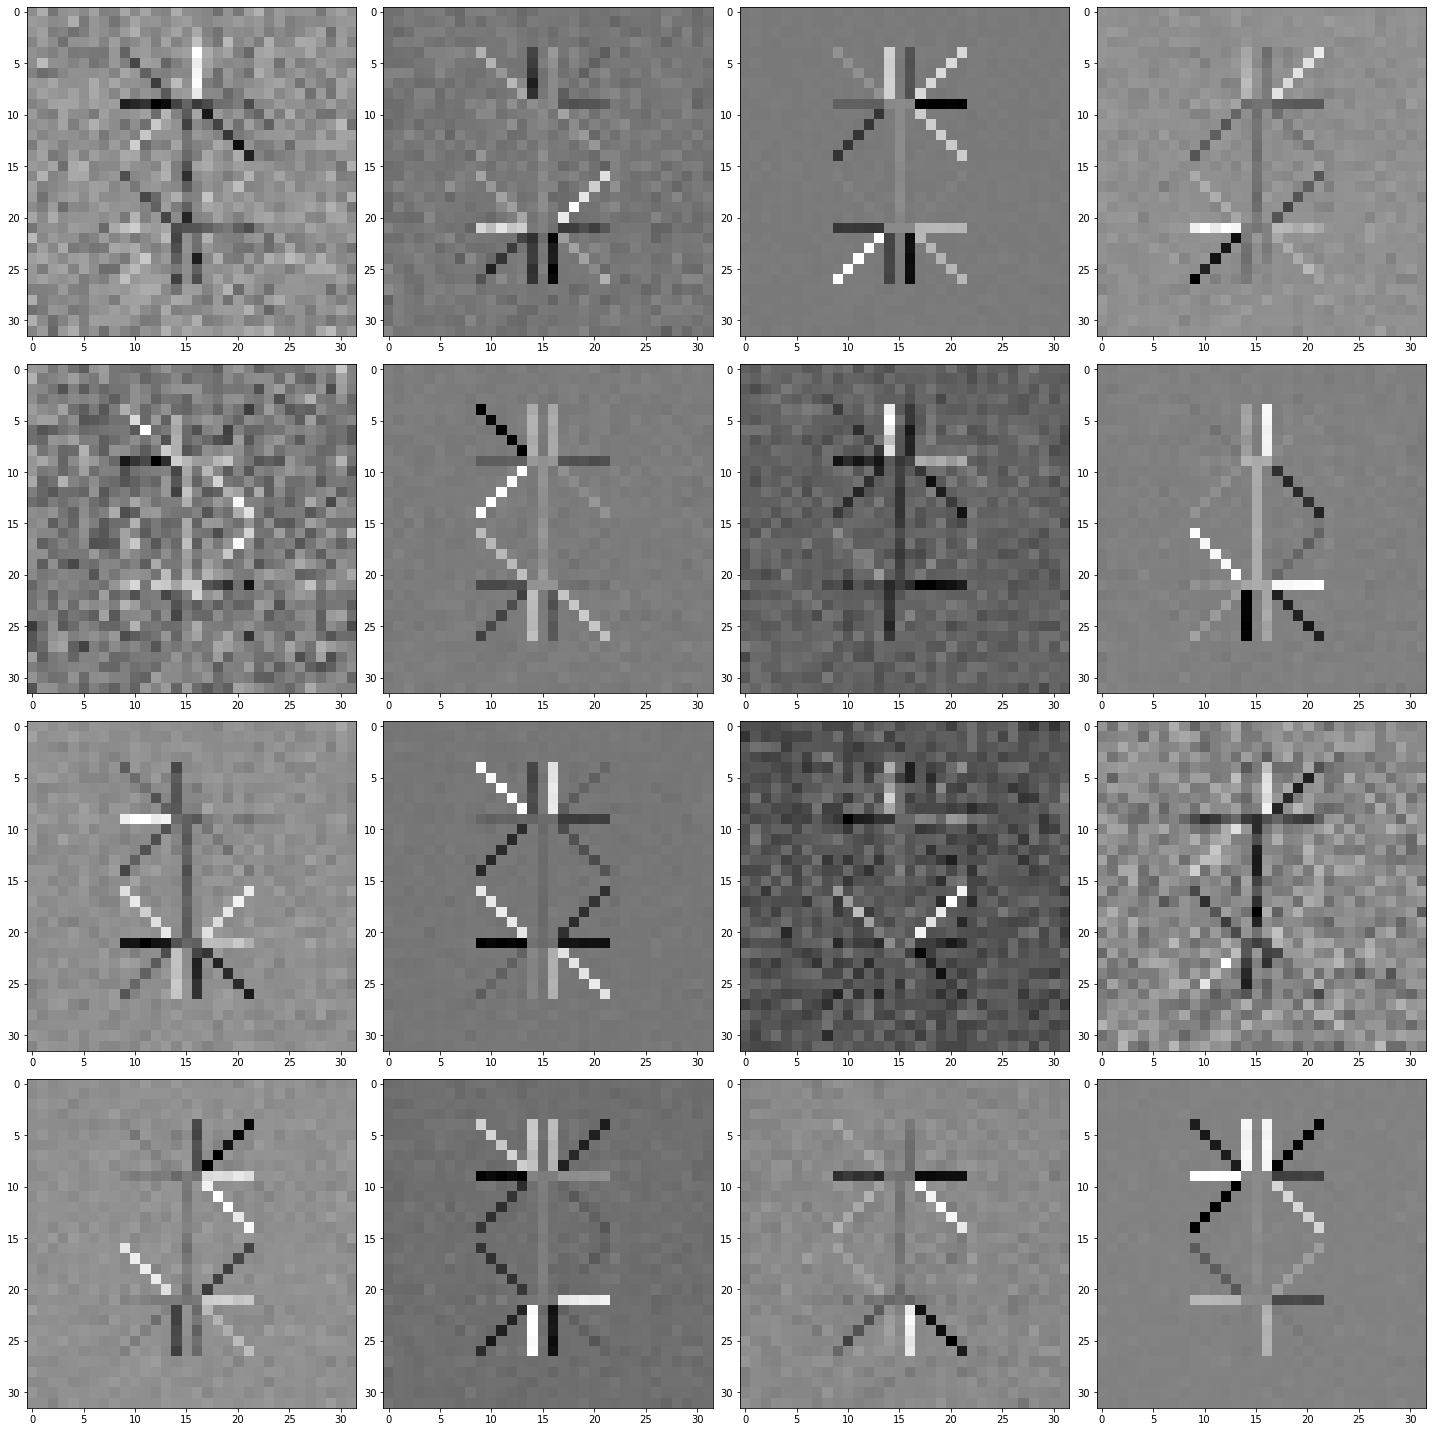

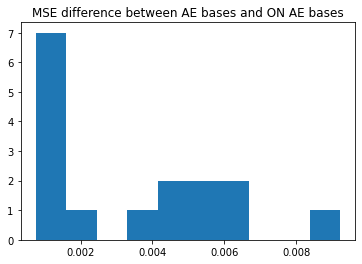

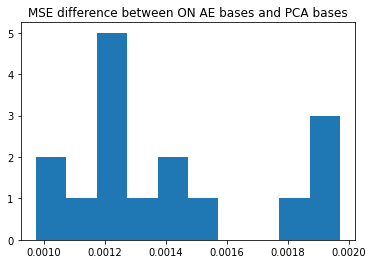

In [13]:
Q, R = np.linalg.qr(bases_AE[:,:,0])

match_AE_Q  = cosine_HA(bases_AE[:,:,0].T, Q.T)
print(np.mean(match_AE_Q[0].diagonal()))
match_PCA_Q = cosine_HA(bases_PCA, Q.T)
print(np.mean(match_PCA_Q[0].diagonal()))
plotimgs(Q)
#plotimgs(bases_AE[:,:,0])

AE_Q = np.zeros(16)
Q_PCA = np.zeros(16)
for i in range(16):
    AE_Q[i] = np.mean((bases_AE[:,match_AE_Q[1][i],0] - Q[:,i])**2)
    Q_PCA[i] = np.mean((bases_PCA.T[:,match_PCA_Q[1][i]] - Q[:,i])**2)

plt.hist(AE_Q)
plt.title("MSE difference between AE bases and ON AE bases")
plt.show()

plt.hist(Q_PCA)
plt.title("MSE difference between ON AE bases and PCA bases")
plt.show()